In [3]:
import glob
import os
from random import shuffle
import time
import numpy as np
import random
import cv2 as cv
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Activation, Input, Dense, Conv2D, Dropout, Flatten
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard
from keras.utils import np_utils

Using TensorFlow backend.


# Define utility and training functions

In [25]:
def get_image_files(root_dir):
    full_paths = [x for x in os.walk(root_dir)]
    imgs = [os.path.join(ds,f) for ds,_,fs in full_paths for f in fs if f]    
    return imgs

def get_dimensions(files):
    min_height, min_width = 10000, 10000
    max_height, max_width = 0, 0
    for f in files:
        img = cv.imread(f)
        h,w = img.shape[:2]
        if h < min_height:
            min_height = h
        if h > max_height:
            max_height = h
        if w < min_width:
            min_width = w
        if w > max_width:
            max_width = w
    return min_height, min_width, max_height, max_width

def make_labels(files):
    # Assume input is a list of complete file paths.
    # Count the number of unique directory names that are immediate parent of the files.
    # Order the directory names alphabetically from a-z, and associate labels accordingly.
    dirs = []
    for f in files:
        dirs.append(f.split('\\')[-2])
    unique_dirs = list(set(dirs))
    unique_dirs.sort()
    label_map = {}
    for i,d in enumerate(unique_dirs):
        label_map[d] = i
    return label_map

def make_train_val(files, label_map):
    train = []
    val = []    
    for k in label_map.keys():
        imgs = [f for f in files if k in f]
        num_files = len(imgs)
        train.extend(imgs[:int(.6*num_files)])
        val.extend(imgs[int(.6*num_files):])
    return train, val

def get_batches(files, label_map, batch_size, resize_size, num_color_channels, augment=False, predict=False):
    shuffle(files)
    count = 0
    num_files = len(files)
    num_classes = len(label_map)
    batch_out = np.zeros((batch_size, resize_size[0], resize_size[1], num_color_channels), dtype=np.uint8)
    labels_out = np.zeros((batch_size,num_classes))    
    while True:
        f = files[count%num_files]
        img = cv.imread(f)        
        res = cv.resize(img, resize_size)
        
        # Augment by randomly flipping the image
        if augment and random.choice([True, False]):
            res = cv.flip(res, random.choice([-1, 0, 1]))
        
        if num_color_channels == 1:
            res = cv.cvtColor(res, cv.COLOR_BGR2GRAY)
            res = res[...,None]
        batch_out[count%batch_size,...] = res
        for k in label_map.keys():
            if k in f:
                labels_out[count%batch_size,:] = np_utils.to_categorical(label_map[k],num_classes)
                break
        count += 1
        if count%batch_size == 0:
            if predict:
                yield batch_out.astype(np.float)/255.
            else:
                yield batch_out.astype(np.float)/255., labels_out
            
# Convnet classifier
class classifier():
    def __init__(self,
                 input_shape,
                 n_classes,
                 n_enc_conv_layers=2,
                 n_enc_conv_filters=[32]*2, # individually customizable
                 enc_kernel_size=[(3,2)]*2, # list of integers or tuples
                 n_dense_layers=1,
                 dense_units=[32],
                 dropout=[0.0]*3, # individually customizable
                 strides=[(2,1)]*2,
                 activation='relu',
                 kernel_initializer='glorot_uniform',
                 l1_reg=0.0,
                 lr=0.001
                ):

        if len(n_enc_conv_filters) == 1:
            n_enc_conv_filters = n_enc_conv_filters*n_enc_conv_layers

        if len(enc_kernel_size) == 1:
            enc_kernel_size = enc_kernel_size*n_enc_conv_layers
            
        if len(dense_units) == 1:
            dense_units = dense_units*n_dense_layers

        if len(dropout) == 1:
            dropout = dropout*(n_enc_conv_layers+n_dense_layers)

        if len(strides) == 1:
            strides = strides*n_enc_conv_layers

        self.input_shape=input_shape
        self.n_classes=n_classes
        self.n_enc_conv_layers=n_enc_conv_layers
        self.n_enc_conv_filters=n_enc_conv_filters
        self.enc_kernel_size=enc_kernel_size
        self.n_dense_layers=n_dense_layers
        self.dense_units=dense_units
        self.dropout=dropout
        self.strides=strides
        self.activation=activation
        self.kernel_initializer = kernel_initializer
        self.l1_reg=l1_reg
        self.lr=lr
        self.model = self.get_model()

    def get_model(self):
        I = Input(shape=self.input_shape, name='input')
        X = I
        # Add Conv layers
        for i in range(self.n_enc_conv_layers):
            X = Conv2D(self.n_enc_conv_filters[i], self.enc_kernel_size[i], strides=self.strides[i], padding='same',
                       data_format='channels_last', kernel_initializer=self.kernel_initializer,
                       kernel_regularizer=l1(self.l1_reg), name='conv_{}'.format(i))(X)
            X = Activation(self.activation)(X)
            X = Dropout(self.dropout[i])(X)
        
        X = Flatten()(X)
        # Add Dense layers
        for i in range(self.n_dense_layers):
            X = Dense(self.dense_units[i], kernel_initializer=self.kernel_initializer,
                      kernel_regularizer=l1(self.l1_reg), name='dense_{}'.format(i))(X)
        X = Activation(self.activation)(X)
        O = Dense(self.n_classes, activation='softmax', kernel_initializer=self.kernel_initializer,
                  kernel_regularizer=l1(self.l1_reg), name='output')(X)
        
        model = Model(inputs=I, outputs=O)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.lr), metrics=['accuracy'])
        return model
    
def train(train_files, val_files, label_map, epochs=100, batch_size=8, common_size=(128,128), num_color_channels=3, 
          new_model=True, save_model_name='classification_model_1.hdf5'):
    num_batches_per_epoch = len(train_files)//batch_size
    
    train_batch_generator = get_batches(train_files, label_map, batch_size, common_size, num_color_channels, True)
    val_batch_generator = get_batches(val_files, label_map, batch_size, common_size, num_color_channels)

    checkpt = ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    if new_model: # create a new model
        model = classifier([common_size[0], common_size[1], num_color_channels],
                           len(label_map),
                           n_enc_conv_layers=6,
                           n_enc_conv_filters=[4]*6,
                           enc_kernel_size=[(3,3)],
                           n_dense_layers=1,
                           dense_units=[4],
                           dropout=[0.0],
                           strides=([(1,1)]*2+[(2,2)])*2,
                           activation='relu',
                           kernel_initializer='glorot_uniform',
                           l1_reg=0.0,
                           lr=0.001).model
    else: # continue to train a previous model
        print('Continuing training from a previous model')
        model = load_model('models/'+save_model_name)

    model.summary()
    model.fit_generator(train_batch_generator, steps_per_epoch=num_batches_per_epoch, epochs=epochs,
                        verbose=1, callbacks=[checkpt, TerminateOnNaN(), TensorBoard(log_dir='logs/')], 
                        validation_data=val_batch_generator, validation_steps=len(val_files)//batch_size)
    return model

def predict(files, label_map, common_size=(128,128), num_color_channels=3, saved_model_name='classification_model_1.hdf5'):
    model = load_model(saved_model_name)
    num_batches_per_epoch = len(files)    
    predict_batch_generator = get_batches(files, {}, batch_size, common_size, num_color_channels)

    predicts = []
    p = model.predict_generator(predict_batch_generator, steps_per_epoch=num_batches_per_epoch)
    print(p)

# Data Preprocessing

In [26]:
# Get full paths to all classification data
# Data is assumed to reside under the directory "root_dir", and data for each class is assumed to reside in a separate subfolder
root_dir = 'Classification_Images\\'
files = get_image_files(root_dir)
print(len(files))
# Get the dimension range of the data for informational purposes
minh,minw,maxh,maxw = get_dimensions(files)
print('Over all images - minimum height: {}, minimum width: {}, maximum height: {}, maximum width:{}'.format(minh,minw,maxh,maxw))
# Assign numerical labels to categories - the number of categories is equal to the number of subfolders
label_map = make_labels(files)
print(label_map)
# Split the data into training and validation
train_files, val_files = make_train_val(files, label_map)
print(len(train_files))
print(len(val_files))

145
Over all images - minimum height: 80, minimum width: 64, maximum height: 272, maximum width:376
{'Protoperidinium': 1, 'Ciliate': 0}
86
59


# Training Classifier

In [27]:
# Train a classifier
# Note: all images are resized to common_size.  Change as desired. 
# Images smaller than common_size will be enlarged using interpolation.  Images larger will be shrunk using decimation.
model = train(train_files, val_files, label_map, epochs=1000, batch_size=8, common_size=(128,128), num_color_channels=3, 
              new_model=True, save_model_name='classification_model_1.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 128, 128, 4)       112       
_________________________________________________________________
activation_56 (Activation)   (None, 128, 128, 4)       0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 128, 128, 4)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 128, 128, 4)       148       
_________________________________________________________________
activation_57 (Activation)   (None, 128, 128, 4)       0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 128, 128, 4)       0         
__________

10/10 [==============================] - 0s 48ms/step - loss: 0.6734 - acc: 0.6125 - val_loss: 0.6789 - val_acc: 0.5893

Epoch 00025: val_loss did not improve
Epoch 26/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.6792 - acc: 0.5875 - val_loss: 0.6743 - val_acc: 0.6071

Epoch 00026: val_loss did not improve
Epoch 27/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6791 - acc: 0.5875 - val_loss: 0.6651 - val_acc: 0.6429

Epoch 00027: val_loss improved from 0.67072 to 0.66512, saving model to classification_model_1.hdf5
Epoch 28/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6695 - acc: 0.6250 - val_loss: 0.6693 - val_acc: 0.6250

Epoch 00028: val_loss did not improve
Epoch 29/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6724 - acc: 0.6125 - val_loss: 0.6830 - val_acc: 0.5714

Epoch 00029: val_loss did not improve
Epoch 30/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6654 - ac


Epoch 00071: val_loss did not improve
Epoch 72/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6627 - acc: 0.6250 - val_loss: 0.6550 - val_acc: 0.6429

Epoch 00072: val_loss did not improve
Epoch 73/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6783 - acc: 0.5875 - val_loss: 0.6700 - val_acc: 0.6071

Epoch 00073: val_loss did not improve
Epoch 74/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6678 - acc: 0.6125 - val_loss: 0.6775 - val_acc: 0.5893

Epoch 00074: val_loss did not improve
Epoch 75/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6731 - acc: 0.6000 - val_loss: 0.6700 - val_acc: 0.6071

Epoch 00075: val_loss did not improve
Epoch 76/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6573 - acc: 0.6375 - val_loss: 0.6549 - val_acc: 0.6429

Epoch 00076: val_loss did not improve
Epoch 77/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6572 - acc: 0.6375


Epoch 00118: val_loss did not improve
Epoch 119/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6537 - val_acc: 0.6429

Epoch 00119: val_loss did not improve
Epoch 120/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.6562 - acc: 0.6375 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00120: val_loss did not improve
Epoch 121/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6562 - acc: 0.6375 - val_loss: 0.6783 - val_acc: 0.5893

Epoch 00121: val_loss did not improve
Epoch 122/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.6791 - acc: 0.5875 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00122: val_loss did not improve
Epoch 123/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6562 - acc: 0.6375 - val_loss: 0.6782 - val_acc: 0.5893

Epoch 00123: val_loss did not improve
Epoch 124/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.6677 - acc: 

10/10 [==============================] - 0s 47ms/step - loss: 0.6559 - acc: 0.6375 - val_loss: 0.6702 - val_acc: 0.6071

Epoch 00166: val_loss did not improve
Epoch 167/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6702 - val_acc: 0.6071

Epoch 00167: val_loss did not improve
Epoch 168/1000
10/10 [==============================] - 0s 47ms/step - loss: 0.6795 - acc: 0.5875 - val_loss: 0.6533 - val_acc: 0.6429

Epoch 00168: val_loss did not improve
Epoch 169/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6785 - val_acc: 0.5893

Epoch 00169: val_loss did not improve
Epoch 170/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.6794 - acc: 0.5875 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00170: val_loss did not improve
Epoch 171/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 001

10/10 [==============================] - 0s 35ms/step - loss: 0.6792 - acc: 0.5875 - val_loss: 0.6946 - val_acc: 0.5536

Epoch 00213: val_loss did not improve
Epoch 214/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6946 - val_acc: 0.5536

Epoch 00214: val_loss did not improve
Epoch 215/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6783 - val_acc: 0.5893

Epoch 00215: val_loss did not improve
Epoch 216/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6734 - acc: 0.6000 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00216: val_loss did not improve
Epoch 217/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6537 - val_acc: 0.6429

Epoch 00217: val_loss did not improve
Epoch 218/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6849 - acc: 0.5750 - val_loss: 0.6864 - val_acc: 0.5714

Epoch 002

10/10 [==============================] - 0s 35ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00260: val_loss did not improve
Epoch 261/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6534 - val_acc: 0.6429

Epoch 00261: val_loss did not improve
Epoch 262/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6450 - val_acc: 0.6607

Epoch 00262: val_loss did not improve
Epoch 263/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6560 - acc: 0.6375 - val_loss: 0.6870 - val_acc: 0.5714

Epoch 00263: val_loss did not improve
Epoch 264/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00264: val_loss did not improve
Epoch 265/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6534 - val_acc: 0.6429

Epoch 002

10/10 [==============================] - 0s 41ms/step - loss: 0.6561 - acc: 0.6375 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00307: val_loss did not improve
Epoch 308/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.6502 - acc: 0.6500 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00308: val_loss did not improve
Epoch 309/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00309: val_loss did not improve
Epoch 310/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00310: val_loss did not improve
Epoch 311/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6736 - acc: 0.6000 - val_loss: 0.6952 - val_acc: 0.5536

Epoch 00311: val_loss did not improve
Epoch 312/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6736 - acc: 0.6000 - val_loss: 0.6951 - val_acc: 0.5536

Epoch 003

10/10 [==============================] - 0s 34ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.7035 - val_acc: 0.5357

Epoch 00354: val_loss did not improve
Epoch 355/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6794 - acc: 0.5875 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00355: val_loss did not improve
Epoch 356/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00356: val_loss did not improve
Epoch 357/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6793 - acc: 0.5875 - val_loss: 0.6535 - val_acc: 0.6429

Epoch 00357: val_loss did not improve
Epoch 358/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 00358: val_loss did not improve
Epoch 359/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 003

10/10 [==============================] - 0s 44ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.7036 - val_acc: 0.5357

Epoch 00401: val_loss did not improve
Epoch 402/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.6794 - acc: 0.5875 - val_loss: 0.6534 - val_acc: 0.6429

Epoch 00402: val_loss did not improve
Epoch 403/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6534 - val_acc: 0.6429

Epoch 00403: val_loss did not improve
Epoch 404/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6868 - val_acc: 0.5714

Epoch 00404: val_loss did not improve
Epoch 405/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00405: val_loss did not improve
Epoch 406/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6560 - acc: 0.6375 - val_loss: 0.6869 - val_acc: 0.5714

Epoch 004

10/10 [==============================] - 0s 36ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 00448: val_loss did not improve
Epoch 449/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6536 - val_acc: 0.6429

Epoch 00449: val_loss did not improve
Epoch 450/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6866 - val_acc: 0.5714

Epoch 00450: val_loss did not improve
Epoch 451/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6949 - val_acc: 0.5536

Epoch 00451: val_loss did not improve
Epoch 452/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00452: val_loss did not improve
Epoch 453/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6948 - val_acc: 0.5536

Epoch 004

10/10 [==============================] - 0s 35ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6452 - val_acc: 0.6607

Epoch 00495: val_loss did not improve
Epoch 496/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6950 - val_acc: 0.5536

Epoch 00496: val_loss did not improve
Epoch 497/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6452 - val_acc: 0.6607

Epoch 00497: val_loss did not improve
Epoch 498/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 00498: val_loss did not improve
Epoch 499/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6451 - val_acc: 0.6607

Epoch 00499: val_loss did not improve
Epoch 500/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6852 - acc: 0.5750 - val_loss: 0.6452 - val_acc: 0.6607

Epoch 005

10/10 [==============================] - 0s 34ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6537 - val_acc: 0.6429

Epoch 00542: val_loss did not improve
Epoch 543/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6791 - acc: 0.5875 - val_loss: 0.6865 - val_acc: 0.5714

Epoch 00543: val_loss did not improve
Epoch 544/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00544: val_loss did not improve
Epoch 545/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6783 - val_acc: 0.5893

Epoch 00545: val_loss did not improve
Epoch 546/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00546: val_loss did not improve
Epoch 547/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6562 - acc: 0.6375 - val_loss: 0.6783 - val_acc: 0.5893

Epoch 005

10/10 [==============================] - 0s 38ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6867 - val_acc: 0.5714

Epoch 00589: val_loss did not improve
Epoch 590/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 00590: val_loss did not improve
Epoch 591/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6535 - val_acc: 0.6429

Epoch 00591: val_loss did not improve
Epoch 592/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6561 - acc: 0.6375 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00592: val_loss did not improve
Epoch 593/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00593: val_loss did not improve
Epoch 594/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 005

10/10 [==============================] - 0s 34ms/step - loss: 0.6505 - acc: 0.6500 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00636: val_loss did not improve
Epoch 637/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6537 - val_acc: 0.6429

Epoch 00637: val_loss did not improve
Epoch 638/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00638: val_loss did not improve
Epoch 639/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00639: val_loss did not improve
Epoch 640/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00640: val_loss did not improve
Epoch 641/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6734 - acc: 0.6000 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 006

10/10 [==============================] - 0s 39ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6785 - val_acc: 0.5893

Epoch 00683: val_loss did not improve
Epoch 684/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00684: val_loss did not improve
Epoch 685/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6736 - acc: 0.6000 - val_loss: 0.6868 - val_acc: 0.5714

Epoch 00685: val_loss did not improve
Epoch 686/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6793 - acc: 0.5875 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00686: val_loss did not improve
Epoch 687/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00687: val_loss did not improve
Epoch 688/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6560 - acc: 0.6375 - val_loss: 0.7034 - val_acc: 0.5357

Epoch 006

10/10 [==============================] - 0s 41ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6783 - val_acc: 0.5893

Epoch 00730: val_loss did not improve
Epoch 731/1000
10/10 [==============================] - 0s 48ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00731: val_loss did not improve
Epoch 732/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.6734 - acc: 0.6000 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00732: val_loss did not improve
Epoch 733/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6454 - val_acc: 0.6607

Epoch 00733: val_loss did not improve
Epoch 734/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.6849 - acc: 0.5750 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 00734: val_loss did not improve
Epoch 735/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6865 - val_acc: 0.5714

Epoch 007

10/10 [==============================] - 0s 37ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 00777: val_loss did not improve
Epoch 778/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00778: val_loss did not improve
Epoch 779/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00779: val_loss did not improve
Epoch 780/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6503 - acc: 0.6500 - val_loss: 0.6452 - val_acc: 0.6607

Epoch 00780: val_loss did not improve
Epoch 781/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00781: val_loss did not improve
Epoch 782/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 007

10/10 [==============================] - 0s 42ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00824: val_loss did not improve
Epoch 825/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.6559 - acc: 0.6375 - val_loss: 0.6533 - val_acc: 0.6429

Epoch 00825: val_loss did not improve
Epoch 826/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6500 - acc: 0.6500 - val_loss: 0.6533 - val_acc: 0.6429

Epoch 00826: val_loss did not improve
Epoch 827/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6736 - acc: 0.6000 - val_loss: 0.6786 - val_acc: 0.5893

Epoch 00827: val_loss did not improve
Epoch 828/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6796 - acc: 0.5875 - val_loss: 0.6702 - val_acc: 0.6071

Epoch 00828: val_loss did not improve
Epoch 829/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.6795 - acc: 0.5875 - val_loss: 0.6449 - val_acc: 0.6607

Epoch 008

10/10 [==============================] - 0s 46ms/step - loss: 0.6734 - acc: 0.6000 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00871: val_loss did not improve
Epoch 872/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6784 - val_acc: 0.5893

Epoch 00872: val_loss did not improve
Epoch 873/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.6734 - acc: 0.6000 - val_loss: 0.6536 - val_acc: 0.6429

Epoch 00873: val_loss did not improve
Epoch 874/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6536 - val_acc: 0.6429

Epoch 00874: val_loss did not improve
Epoch 875/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.6734 - acc: 0.6000 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00875: val_loss did not improve
Epoch 876/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6619 - val_acc: 0.6250

Epoch 008

10/10 [==============================] - 0s 45ms/step - loss: 0.6448 - acc: 0.6625 - val_loss: 0.6783 - val_acc: 0.5893

Epoch 00918: val_loss did not improve
Epoch 919/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6619 - acc: 0.6250 - val_loss: 0.6536 - val_acc: 0.6429

Epoch 00919: val_loss did not improve
Epoch 920/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.6677 - acc: 0.6125 - val_loss: 0.6618 - val_acc: 0.6250

Epoch 00920: val_loss did not improve
Epoch 921/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00921: val_loss did not improve
Epoch 922/1000
10/10 [==============================] - 0s 47ms/step - loss: 0.6618 - acc: 0.6250 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00922: val_loss did not improve
Epoch 923/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.6560 - acc: 0.6375 - val_loss: 0.6535 - val_acc: 0.6429

Epoch 009

10/10 [==============================] - 0s 34ms/step - loss: 0.6676 - acc: 0.6125 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00965: val_loss did not improve
Epoch 966/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.6560 - acc: 0.6375 - val_loss: 0.6952 - val_acc: 0.5536

Epoch 00966: val_loss did not improve
Epoch 967/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.6560 - acc: 0.6375 - val_loss: 0.6701 - val_acc: 0.6071

Epoch 00967: val_loss did not improve
Epoch 968/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6785 - val_acc: 0.5893

Epoch 00968: val_loss did not improve
Epoch 969/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.6735 - acc: 0.6000 - val_loss: 0.6535 - val_acc: 0.6429

Epoch 00969: val_loss did not improve
Epoch 970/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.6736 - acc: 0.6000 - val_loss: 0.6866 - val_acc: 0.5714

Epoch 009

# Prediction on New Data

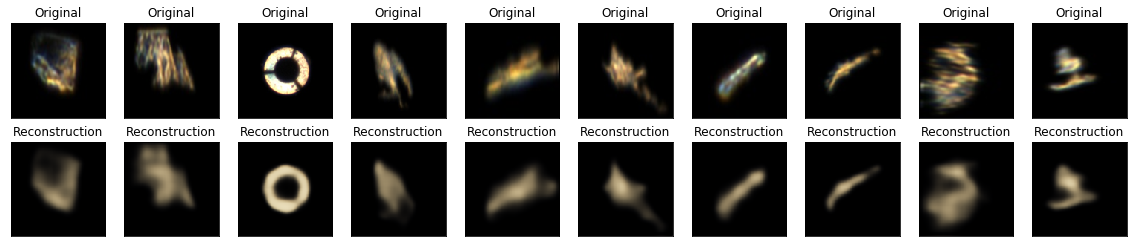

In [11]:
# If a model has already been trained and saved, then load it here directly without having to run training again.

batch_size = 10
g = get_batches(train_files, batch_size, (128,128), num_color_channels=3)
for i in range(np.random.randint(len(train_files)//batch_size)):
    x_test, _ = next(g)
decoded_imgs = model.predict(x_test)

plt.figure(figsize=(20, 4))
for i in range(batch_size):
    # display original
    ax = plt.subplot(2, batch_size, i+1)
    plt.imshow(np.uint8(x_test[i,...,::-1]*255))
    ax.set_title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, batch_size, i + batch_size + 1)
    plt.imshow(np.uint8(decoded_imgs[i,...,::-1]*255))
    ax.set_title('Reconstruction')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()